# 09 Smart Home Use Cases on Forecast

## Notebook Overview

This notebook demonstrates **practical downstream applications** of the trained LightGBM forecast model—transforming predictions into real-time smart home insights.

**Key Use Cases:**

* **Grid demand vs. solar generation:**
  Calculates net load and flags self-sufficiency periods → enables solar-aligned appliance scheduling
* **High usage warnings:**
  Flags future time windows where predicted consumption exceeds a critical threshold (e.g. 1.5 kW) → supports early user alerts or load shifting

> Purpose: Show how accurate short-term forecasts can power intelligent decision-making, improve energy efficiency, and reduce grid dependency in real-world smart home settings.

### Thoughts, Tradeoffs & Considerations

* **Forecast-to-decision chain:** The logic here closes the loop from numeric prediction to actionable decisions. This structure works well for prototyping, but requires more formal abstraction (e.g. rules engine or policy layer) if scaled beyond basic alerts.

* **Dependency on solar data:** All solar-alignment logic assumes accurate `generated_solar` input. If this comes from a separate forecast model, error compounding becomes an issue. For reliability, solar data must either be high-quality measured input or paired with uncertainty-aware forecasting.

* **Threshold design:** The 1.5 kW usage warning threshold is static. This works for demonstration, but in practice should be dynamic—learned from historical consumption, aligned with tariffs, or personalized to user behavior.

* **Alert fatigue risk:** Naively firing a binary warning every time the threshold is crossed can overwhelm users. Considerations like aggregation (“3 high-usage windows today”), relevance filtering, or action recommendations (e.g. “delay EV charging to 2 PM”) are needed for a production-ready alerting layer.

* **No context-aware automation yet:** Alerts are generated, but no downstream control logic is triggered. In a real smart home, these outputs would feed into scheduling agents or appliance controllers. Current setup shows the logic backbone but not the full loop.

* **Explainability missing in output:** Users are shown warnings or grid dependency, but not why. Integrating explainability (e.g. top SHAP driver = fridge, HVAC) would improve trust and decision acceptance.

* **Assumes hourly resolution and complete data:** This system depends on timely, regular, high-resolution input. It assumes no data gaps, low latency, and available downstream systems. Any real-world deployment would need fallback logic for degraded operation.

* **Scalability considerations:** The logic here is household-specific. To scale across many households, additional layers are needed—like user profiles, appliance detection, and dynamic policy generation.

> This notebook shows the first step toward turning predictions into energy-aware behavior. The insights are useful, but the real challenge lies in scaling these decisions reliably, explainably, and without overwhelming the user.

In [13]:
import pandas as pd
from pandas import DataFrame
import pickle
import joblib

import matplotlib.pyplot as plt

from typing import List

In [14]:
train_df = pd.read_csv("../data/interim/train.csv", index_col="time", parse_dates=True)
forecast_df = pd.read_csv("../data/interim/forecast.csv", index_col="time", parse_dates=True)

In [15]:
features: list[str] = [col for col in train_df.columns if col not in ["use_house_overall", "time"]]
target: str = "use_house_overall"

In [16]:
# Load model
model = joblib.load("../models/lgbm_model.pkl")

# Load features
with open("../models/lgbm_features.pkl", "rb") as f:
    features: List[str] = pickle.load(f)

In [17]:
# Prepare features
X_forecast: DataFrame = forecast_df[features]

In [18]:
forecast_df = forecast_df.drop(columns=["use_house_overall"])

In [19]:
# Predict
forecast_df["predicted"] = model.predict(X_forecast)

---

## 1. Compare Consumption vs. Solar Forecast (Net Load & Self-Consumption)

In [20]:
def calculate_grid_demand_and_self_sufficiency(forecast_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate grid demand (i.e. predicted consumption minus available solar generation)
    and flag whether the household can be self-sufficient at each time step.
    
    Parameters:
        forecast_df (pd.DataFrame): DataFrame containing 'predicted' and 'generated_solar' columns.
    """
    forecast_df["grid_demand"] = forecast_df["predicted"] - forecast_df["generated_solar"]
    forecast_df["self_sufficient"] = forecast_df["grid_demand"] <= 0
    return forecast_df


def plot_consumption_vs_solar_and_grid_demand(
    df: pd.DataFrame,
    consumption_col: str = "predicted",
    solar_col: str = "generated_solar",
    grid_demand_col: str = "grid_demand"
) -> None:
    """
    Plot predicted household consumption, solar power generation, and resulting grid demand.

    Parameters:
        df (pd.DataFrame): DataFrame containing relevant columns.
        consumption_col (str): Column name for predicted energy consumption.
        solar_col (str): Column name for solar generation.
        grid_demand_col (str): Column name for grid demand (consumption - generation).
    """
    plt.figure(figsize=(12, 6))
    
    plt.plot(df.index, df[consumption_col], label="Predicted Consumption", color="orange")
    plt.plot(df.index, df[solar_col], label="Solar Generation", color="green")
    plt.plot(df.index, df[grid_demand_col], label="Grid Demand", color="blue", linestyle="--")

    plt.axhline(0, color="gray", linestyle=":", linewidth=1)
    plt.title("Predicted Consumption, Solar Generation, and Grid Demand")
    plt.xlabel("Time")
    plt.ylabel("kW")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

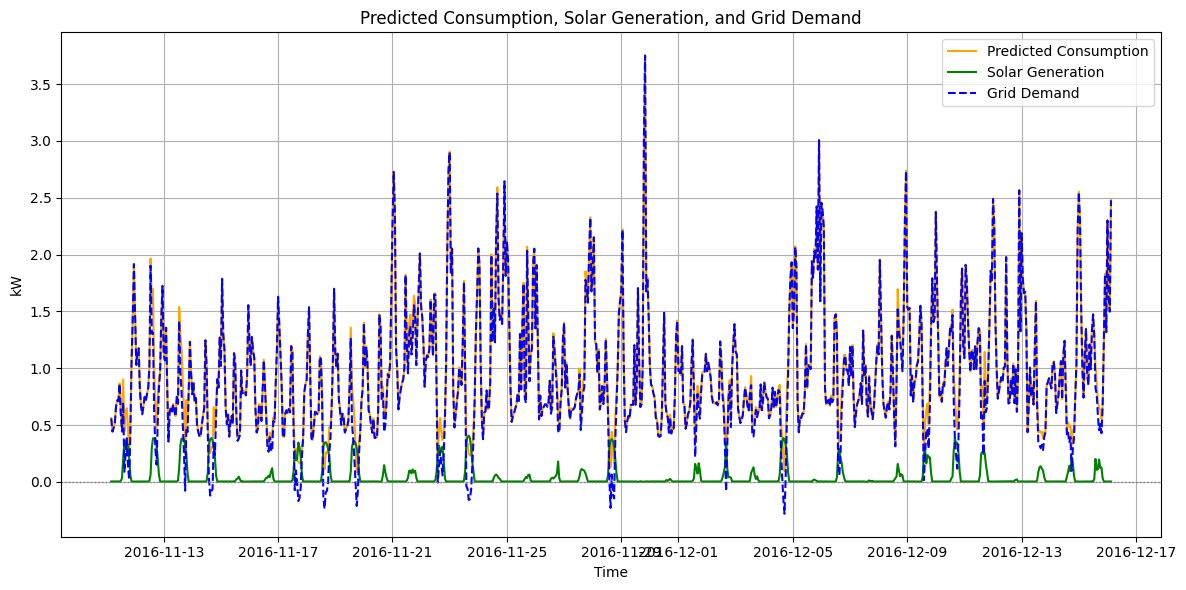

In [21]:
forecast_df = calculate_grid_demand_and_self_sufficiency(forecast_df)
plot_consumption_vs_solar_and_grid_demand(forecast_df)

**Grid Demand vs. Solar Generation**

This plot compares the **predicted household energy consumption**, **solar generation**, and the resulting **grid demand** over time. Grid demand is calculated as the difference between consumption and solar generation. When this value is high, the household relies more on external energy sources. When it’s near zero or negative, solar power is sufficient to meet or even exceed the demand—enabling self-sufficiency or surplus feed-in.

In the displayed time window, **solar generation remains consistently low**, leading to a **positive grid demand throughout**. This indicates that the household is **fully dependent on the grid**, and shifting flexible loads (like EV charging or laundry) to periods with higher solar output could improve self-consumption. While the forecast model is accurate, the solar production pattern highlights **limited opportunity for optimization on this day**—perhaps due to overcast conditions.

This type of analysis forms the basis for **smart scheduling recommendations** in energy-aware homes.

---

## 2. High Usage Warning Logic (Forecast-Based)

In [22]:
def add_high_usage_warning(
    forecast_df: pd.DataFrame,
    predicted_col: str = "predicted",
    threshold_kw: float = 1.5
) -> pd.DataFrame:
    """
    Add a binary warning column for high energy usage based on forecasted consumption.
    """
    forecast_df["high_usage_warning"] = forecast_df[predicted_col] > threshold_kw
    return forecast_df

In [23]:
def plot_high_usage_warnings(
    forecast_df: pd.DataFrame,
    predicted_col: str = "predicted",
    warning_col: str = "high_usage_warning"
) -> None:
    """
    Visualize predicted consumption and highlight high usage warning periods.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(forecast_df.index, forecast_df[predicted_col], label="Predicted Consumption", color="orange")

    high_usage_mask = forecast_df[warning_col]
    plt.scatter(
        forecast_df.index[high_usage_mask],
        forecast_df[predicted_col][high_usage_mask],
        color="red", label="High Usage Warning", marker="x", zorder=5
    )

    plt.axhline(1.5, color="gray", linestyle="--", linewidth=1)
    plt.title("Forecasted Consumption with High Usage Warnings")
    plt.xlabel("Time")
    plt.ylabel("kW")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

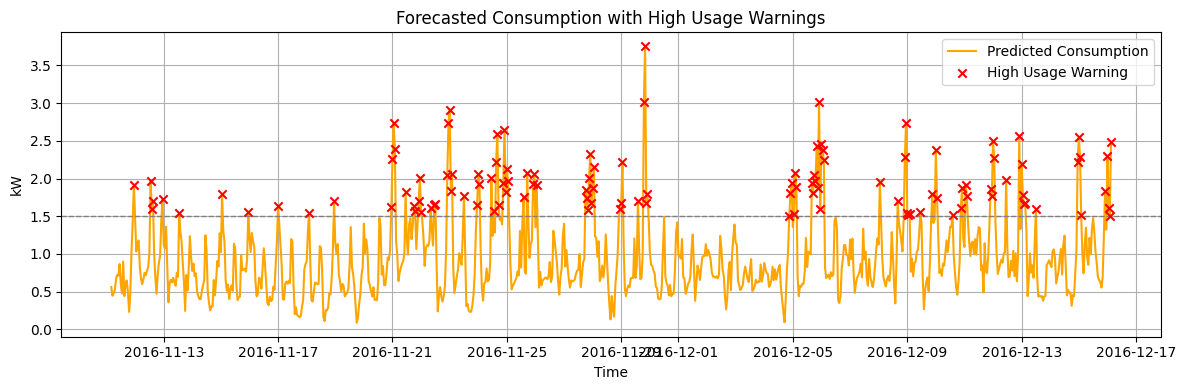

In [24]:
forecast_df = add_high_usage_warning(forecast_df, predicted_col="predicted", threshold_kw=1.5)
plot_high_usage_warnings(forecast_df)

**Forecast-Based Usage Warnings**

This chart shows the predicted energy consumption per hour alongside a warning threshold of 1.5 kW. Each red × marks a time period where predicted usage exceeds that threshold.

In practice, this logic could be used in a smart home assistant to:

* Trigger notifications before expected consumption peaks
* Advise users to shift flexible loads (e.g., dishwasher, laundry)
* Prevent costly peak usage if on variable-rate tariffs
* Enable grid-aware automation, e.g., reduce load during demand spikes

The threshold can be adapted per user preferences or tied to fuse limits, solar availability, or energy pricing windows.